In [5]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from src.detectors import LSHiForest
import data_loader as dl
import config
import numpy as np

In [6]:
# dataのロード:cic
X_train, y_train, X_test, y_test = dl.load_cic_ids()
y_test = np.array([0 if label == "Benign" else 1 for label in y_test])
print(len(X_train))
print(len(X_test))

29101
15000


In [7]:
# cicで実験
num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), 
    ("L1SH", LSHiForest('L1SH', num_ensemblers)),
    ("L2SH", LSHiForest('L2SH', num_ensemblers)), 
    ("ALSH", LSHiForest('ALSH', num_ensemblers))
    ]


for i, (clf_name, clf) in enumerate(classifiers):
	
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time
	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, y_pred)
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.37452841067408893
	Training time:	 0.1143338680267334
	Testing time:	 0.04554009437561035

L1SH:
	AUC score:	 0.21070553774650314
	Training time:	 4.25228214263916
	Testing time:	 15.038326025009155

L2SH:
	AUC score:	 0.2433284238165074
	Training time:	 4.345818281173706
	Testing time:	 19.946918725967407

ALSH:
	AUC score:	 0.2621026774366578
	Training time:	 4.4611828327178955
	Testing time:	 18.361445903778076


In [10]:
# dataのロード:unsw
X_train, y_train, X_test, y_test = dl.load_unsw_nb15()

print(len(X_train))
print(len(X_test))

56000
82332


In [11]:
# UNSWで実験
num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), 
    ("L1SH", LSHiForest('L1SH', num_ensemblers)),
    ("L2SH", LSHiForest('L2SH', num_ensemblers)), 
    ("ALSH", LSHiForest('ALSH', num_ensemblers))
    ]


for i, (clf_name, clf) in enumerate(classifiers):
	
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time
	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, -y_pred)
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.6239269154776412
	Training time:	 0.13300776481628418
	Testing time:	 0.2107222080230713

L1SH:
	AUC score:	 0.7451530122507577
	Training time:	 7.489372968673706
	Testing time:	 66.20689415931702

L2SH:
	AUC score:	 0.7713520593411729
	Training time:	 7.019947052001953
	Testing time:	 93.41742491722107

ALSH:
	AUC score:	 0.750932001974621
	Training time:	 6.334143161773682
	Testing time:	 98.9474048614502



Training and Predicting with sklearn.ISO...

Training and Predicting with L1SH...

Training and Predicting with L2SH...

Training and Predicting with ALSH...


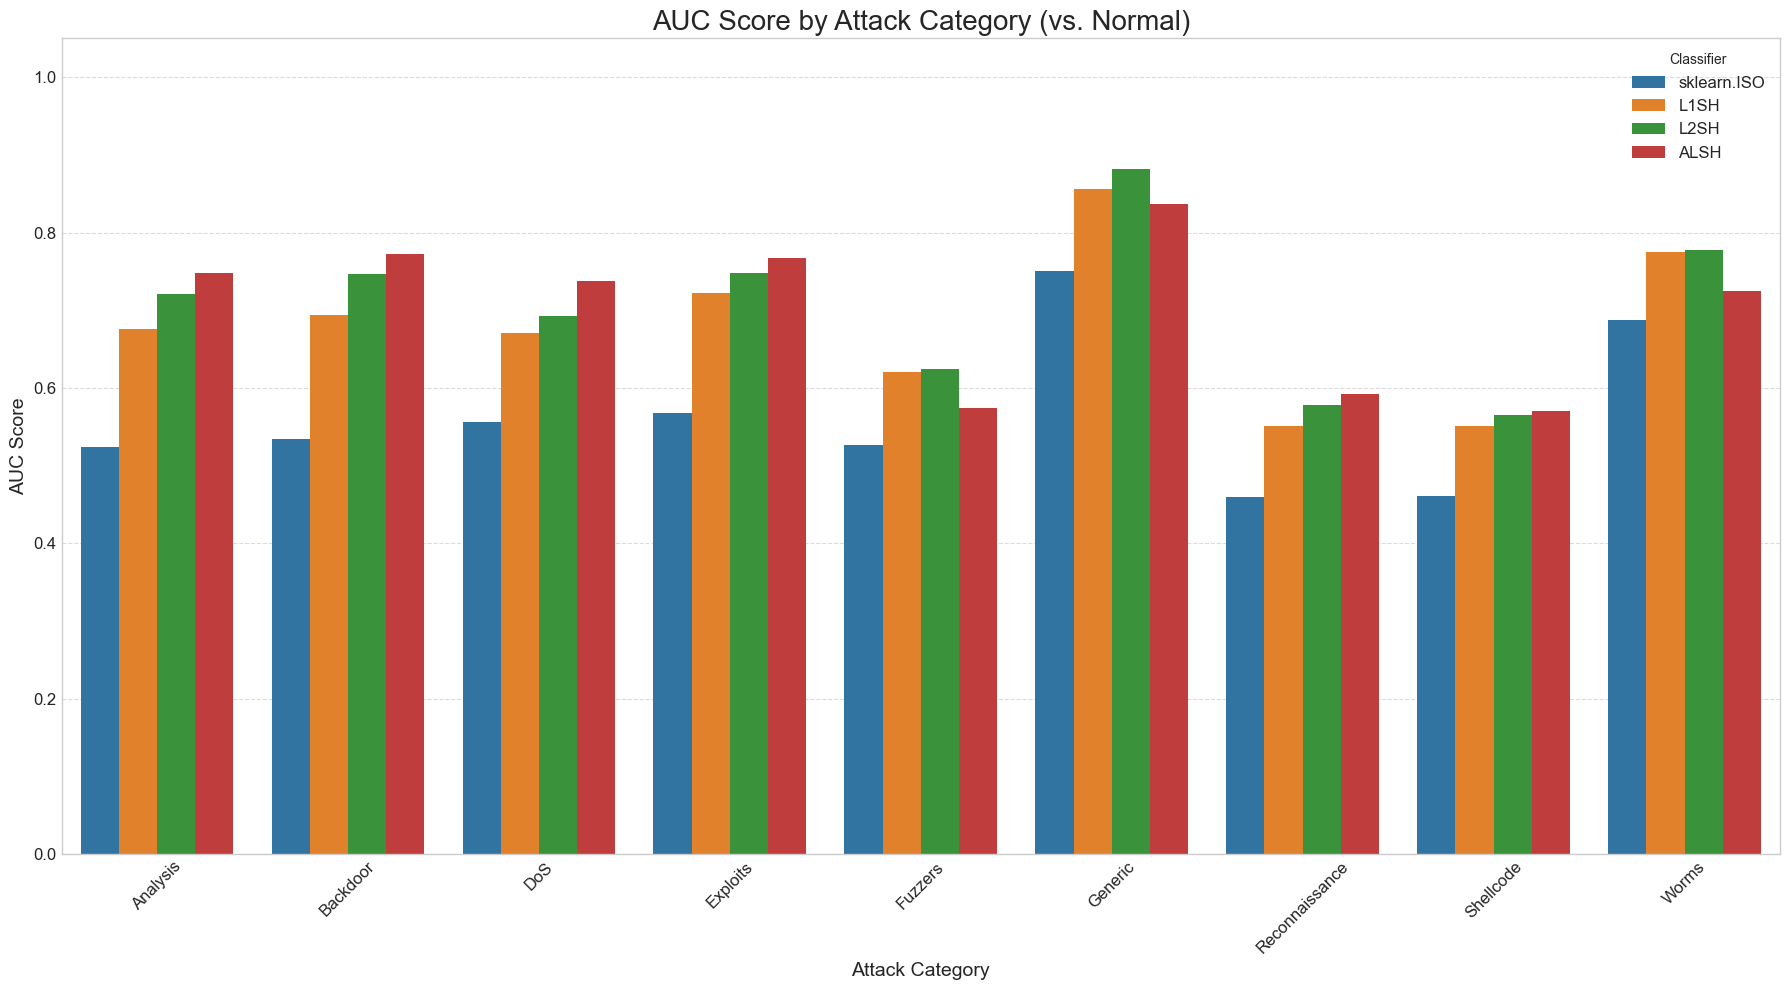

Corrected AUC Scores (Each Attack vs. Normal):
                sklearn.ISO   L1SH   L2SH   ALSH
Analysis             0.5237 0.6766 0.7216 0.7484
Backdoor             0.5351 0.6947 0.7473 0.7727
DoS                  0.5560 0.6710 0.6924 0.7384
Exploits             0.5683 0.7230 0.7481 0.7673
Fuzzers              0.5265 0.6211 0.6243 0.5738
Generic              0.7511 0.8568 0.8821 0.8364
Reconnaissance       0.4598 0.5518 0.5786 0.5930
Shellcode            0.4612 0.5510 0.5648 0.5702
Worms                0.6880 0.7758 0.7775 0.7247


In [12]:
num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), 
    ("L1SH", LSHiForest('L1SH', num_ensemblers)),
    ("L2SH", LSHiForest('L2SH', num_ensemblers)), 
    ("ALSH", LSHiForest('ALSH', num_ensemblers))
    ]

attack_cat_series = pd.read_csv('../data/unsw_nb15/UNSW_NB15_training-set.csv')['attack_cat']

results_df = pd.DataFrame({
    'attack_cat': attack_cat_series.values,
    'label': y_test.values
}, index=y_test.index)

if results_df is not None:
    for clf_name, clf in classifiers:
        print(f"\nTraining and Predicting with {clf_name}...")
        clf.fit(X_train)
        y_pred = clf.decision_function(X_test)
        results_df[f'pred_{clf_name}'] = y_pred

    normal_df = results_df[results_df['label'] == 0]
    attack_df = results_df[results_df['label'] == 1]
    
    corrected_auc_scores = {}
    for clf_name, _ in classifiers:
        scores = {}
        unique_attack_cats = sorted(attack_df['attack_cat'].unique())
        for cat in unique_attack_cats:
            current_attack_df = attack_df[attack_df['attack_cat'] == cat]
            eval_df = pd.concat([normal_df, current_attack_df])
            eval_preds = eval_df[f'pred_{clf_name}']
            eval_labels = eval_df['label']
            auc = roc_auc_score(eval_labels, -eval_preds)
            scores[cat] = auc
        corrected_auc_scores[clf_name] = scores

    # グラフ描画と結果表示
    plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
    plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax)
    ax.set_title('AUC Score by Attack Category (vs. Normal)', fontsize=20)
    ax.set_xlabel('Attack Category', fontsize=14)
    ax.set_ylabel('AUC Score', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(title='Classifier', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("Corrected AUC Scores (Each Attack vs. Normal):")
    pd.options.display.float_format = '{:.4f}'.format
    results_table = pd.DataFrame(corrected_auc_scores)
    print(results_table)

In [5]:
# データの準備:nsl
X_train, y_train, X_test, y_test = dl.load_nsl_kdd()

print(f"Train data size :{len(X_train)}")
print(f"Test data size :{len(X_test)}")

Train data size :67343
Test data size :22544


In [ ]:
# nslで実験
num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), 
    ("L1SH", LSHiForest('L1SH', num_ensemblers)),
    ("L2SH", LSHiForest('L2SH', num_ensemblers)), 
    ("ALSH", LSHiForest('ALSH', num_ensemblers))
    ]
    
for i, (clf_name, clf) in enumerate(classifiers):
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time

	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, -y_pred) # なぜ反転させている？
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.9114241684422666
	Training time:	 0.11903595924377441
	Testing time:	 0.06716012954711914

L1SH:
	AUC score:	 0.9145649246068066
	Training time:	 8.552365064620972
	Testing time:	 20.158140897750854

L2SH:
	AUC score:	 0.9153750231210545
	Training time:	 9.240540266036987
	Testing time:	 27.719343900680542

ALSH:
	AUC score:	 0.919441768937938
	Training time:	 7.9037158489227295
	Testing time:	 27.527488946914673



Training and Predicting with sklearn.ISO...

Training and Predicting with ALSH...

Training and Predicting with L2SH...

Training and Predicting with L1SH...

--- All predictions are stored in results_df ---


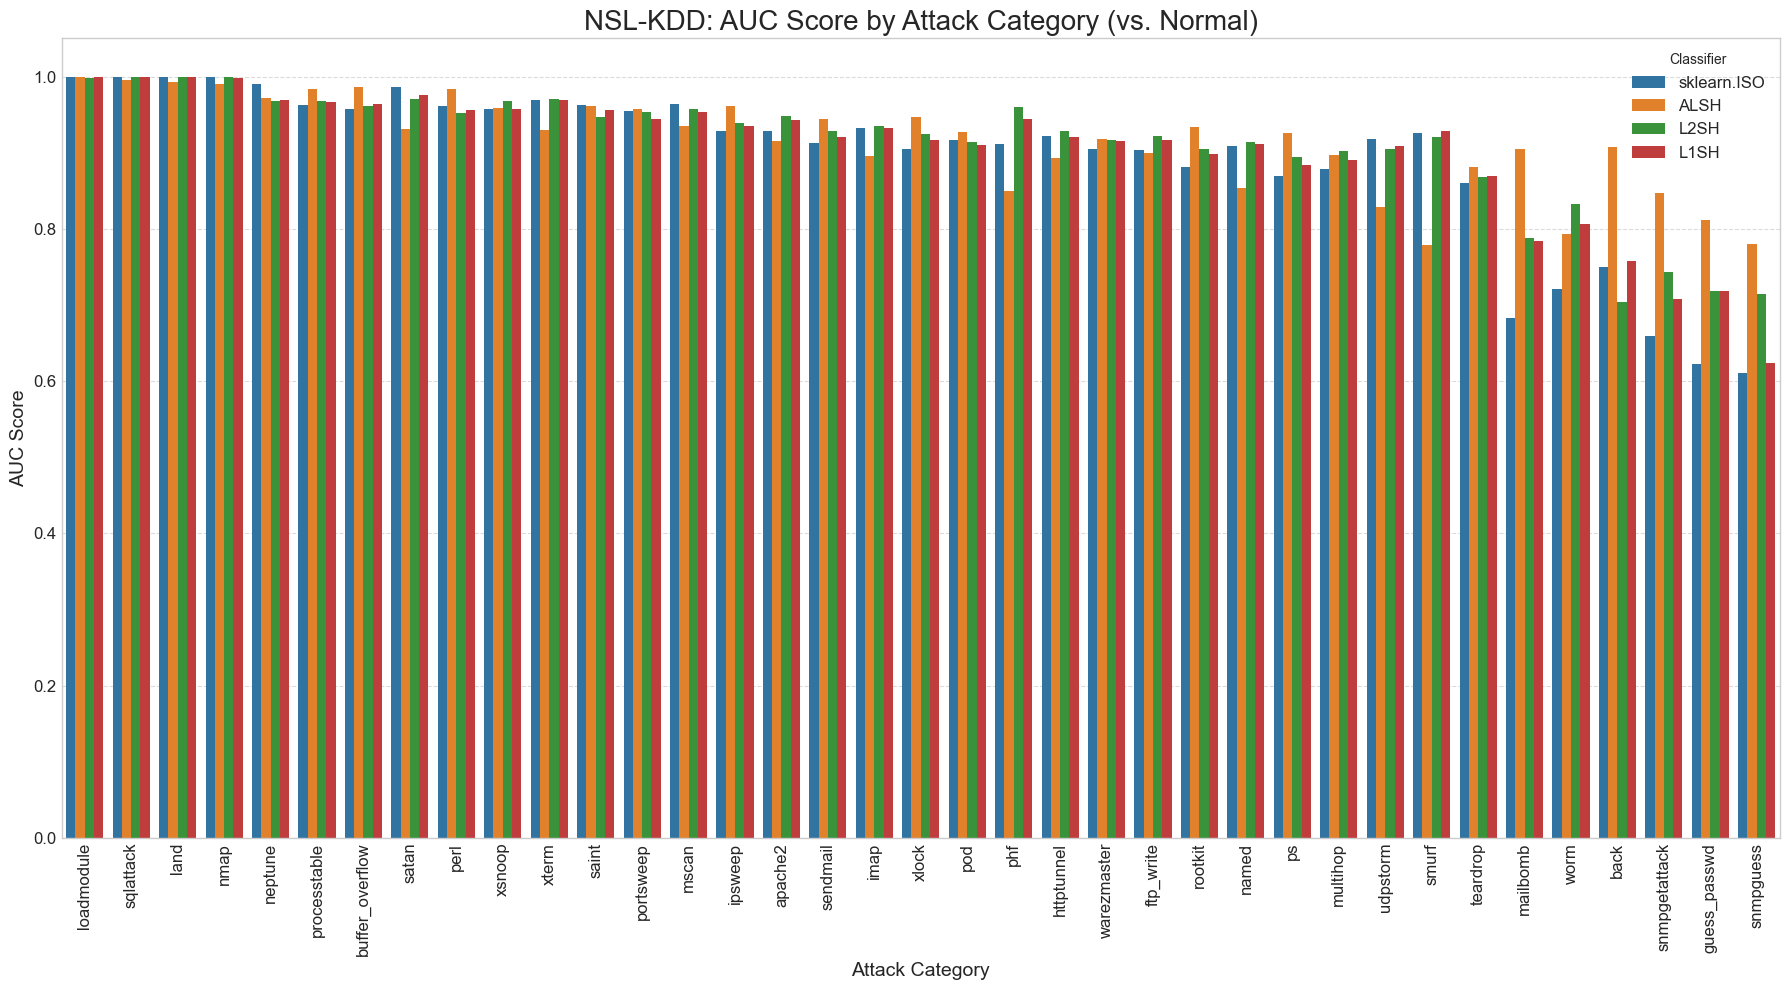


Corrected AUC Scores for NSL-KDD (Each Attack vs. Normal):
                 sklearn.ISO   ALSH   L2SH   L1SH
Attack Category                                  
loadmodule            0.9989 0.9998 0.9982 0.9989
sqlattack             0.9994 0.9958 0.9990 0.9997
land                  0.9995 0.9931 0.9997 0.9999
nmap                  0.9990 0.9908 0.9997 0.9987
neptune               0.9896 0.9718 0.9682 0.9693
processtable          0.9627 0.9841 0.9684 0.9661
buffer_overflow       0.9569 0.9859 0.9618 0.9635
satan                 0.9868 0.9313 0.9708 0.9756
perl                  0.9617 0.9831 0.9516 0.9561
xsnoop                0.9574 0.9589 0.9678 0.9576
xterm                 0.9694 0.9301 0.9710 0.9691
saint                 0.9623 0.9614 0.9464 0.9564
portsweep             0.9542 0.9574 0.9538 0.9447
mscan                 0.9633 0.9352 0.9571 0.9540
ipsweep               0.9282 0.9614 0.9385 0.9352
apache2               0.9287 0.9152 0.9485 0.9435
sendmail              0.9122 0.9441 0.92

In [ ]:
# nslの攻撃種別の結果の表示
num_ensemblers = 100
classifiers = [
("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)),
("ALSH", LSHiForest('ALSH', num_ensemblers)),
("L2SH", LSHiForest('L2SH', num_ensemblers)),
("L1SH", LSHiForest('L1SH', num_ensemblers))
]

results_df_created = False
test_df_for_cat = pd.read_csv('../data/nsl_kdd/KDDTest+.txt', header=None, names=config.columns_nsl)
attack_cat_series = test_df_for_cat['class'].str.strip()
results_df_created = True


results_df = pd.DataFrame({
    'attack_cat': attack_cat_series.values,
    'label': y_test.values
}, index=y_test.index)

for clf_name, clf in classifiers:
    print(f"\nTraining and Predicting with {clf_name}...")
    clf.fit(X_train)
    y_pred = clf.decision_function(X_test)
    results_df[f'pred_{clf_name}'] = y_pred
print("\n--- All predictions are stored in results_df ---")

normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

corrected_auc_scores = {}
for clf_name, _ in classifiers:
    scores = {}
    unique_attack_cats = sorted([cat for cat in attack_df['attack_cat'].unique() if cat != 'normal'])
    for cat in unique_attack_cats:
        current_attack_df = attack_df[attack_df['attack_cat'] == cat]
        eval_df = pd.concat([normal_df, current_attack_df])
        eval_preds = eval_df[f'pred_{clf_name}']
        eval_labels = eval_df['label']
        
        if len(eval_labels.unique()) > 1:
            auc = roc_auc_score(eval_labels, -eval_preds) # なぜ反転させている？
            scores[cat] = auc
        else:
            scores[cat] = None
    corrected_auc_scores[clf_name] = scores

# --- 5. グラフ描画と結果表示 ---
plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()
category_order = plot_df_melted.groupby('Attack Category')['AUC Score'].mean().sort_values(ascending=False).index

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax, order=category_order)

ax.set_title('NSL-KDD: AUC Score by Attack Category (vs. Normal)', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=90, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='Classifier', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('resutls/nsl_kdd_auc_by_category.png')
plt.show()

print("\nCorrected AUC Scores for NSL-KDD (Each Attack vs. Normal):")
pd.options.display.float_format = '{:.4f}'.format
results_table = pd.DataFrame(corrected_auc_scores).reindex(category_order, axis=0) 
print(results_table)